In [1]:
import glob
import os
from torch.utils.data import Dataset
from pathlib import Path
import torchaudio
import torch
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import librosa
from typing import Optional
from transformers import ASTFeatureExtractor
import warnings
from helper.augmentations import apply_augmentations, apply_random_augmentation  # Assume this function exists
from helper.util import AudioDataset, train_test_split_custom

from dotenv import dotenv_values
import wandb


# DESCRIPTION
from helper.util import train_test_split_custom, save_model, wandb_login
from helper.engine import train, inference_loop
from helper.model import auto_extractor, custom_AST

import torch
from torch.utils.data import DataLoader
from torch.optim.adamw import AdamW
# import torch.optim as optim # type: ignore
import torch.nn as nn
from torchinfo import summary
import yaml

import wandb




In [2]:


with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

device = "cuda" if torch.cuda.is_available() else "cpu"

general_config = config['general']
run_config = config['wandb']

data_path = general_config['data_path']
model_name = general_config["model_name"]
BATCH_SIZE = general_config['batch_size']
SEED = general_config['seed']
EPOCHS = general_config['epochs']
NUM_CUDA_WORKERS = general_config['num_cuda_workers']
PINNED_MEMORY = True
SHUFFLED = general_config['shuffled']
ACCUMULATION_STEPS = general_config['accumulation_steps']
learning_rate = general_config['learning_rate']
TRAIN_PATIENCE = general_config['patience']
SAVE_MODEL = general_config['save_model']
test_size = general_config['test_size']
inference_size = general_config['inference_size']
training_transforms = general_config['training_transforms']

wandb_params = {
        "project": run_config['project'],
        "name": run_config['name'],
        "reinit": run_config['reinit'],
        "notes" : run_config['notes'],
        "tags": run_config['tags'],
        "dir" : run_config['dir'],
        "config": general_config
    }

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

feature_extractor = auto_extractor(model_name)

# dataset = AudioDataset(data_path, feature_extractor)

train_dataset, train_val_dataset, test_dataset, inference_dataset = train_test_split_custom(data_path, 
                                                                        feature_extractor, 
                                                                        test_size=test_size, 
                                                                        seed=SEED, 
                                                                        inference_size=inference_size)



num_classes = len(train_dataset.get_classes()) 

model = custom_AST(model_name, num_classes, device)

# summary(model,
#         col_names=["num_params","trainable"],
#         col_width=20,
#         row_settings=["var_names"])
# print(model)

train_dataloader_custom = DataLoader(dataset=train_dataset, 
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_CUDA_WORKERS,
                                    pin_memory=PINNED_MEMORY,
                                    shuffle=SHUFFLED)
train_val_dataloader_custom = DataLoader(dataset=train_val_dataset, 
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_CUDA_WORKERS,
                                    pin_memory=PINNED_MEMORY,
                                    shuffle=SHUFFLED)

test_dataloader_custom = DataLoader(dataset=test_dataset,
                                    batch_size=BATCH_SIZE, 
                                    num_workers=NUM_CUDA_WORKERS,
                                    pin_memory=PINNED_MEMORY,
                                    shuffle=SHUFFLED)

inference_dataloader_custom  = DataLoader(dataset=inference_dataset,
                                batch_size=BATCH_SIZE, 
                                num_workers=NUM_CUDA_WORKERS,
                                pin_memory=PINNED_MEMORY,
                                 shuffle =SHUFFLED) 

Train: 539, Validation: 90, Test: 180, Inference: 91
ASTForAudioClassification(
  (audio_spectrogram_transformer): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTSdpaAttention(
            (attention): ASTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
         

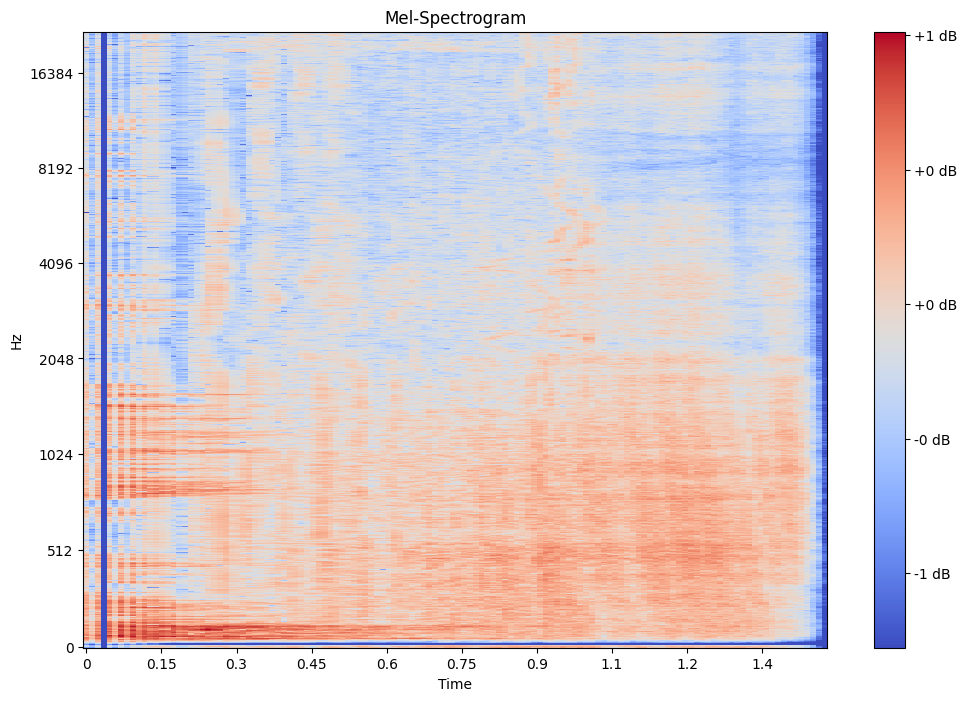

In [8]:
train_dataloader_custom.dataset.show_spectrogram(500)